In [1]:
%%capture
!pip install datasets
!pip install transformers

import datasets as datasets
import transformers

In [2]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token¯

train_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="train")
val_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="validation[:10%]")

In [3]:
# Print the size of the training data
print("Size of Training Data:", len(train_data))

# Print the size of the validation data
print("Size of Validation Data:", len(val_data))

print("Example of Training Data:")
print(train_data[0])

print("Example of Validation Data:")
print(val_data[0])

Size of Training Data: 287113
Size of Validation Data: 1337
Example of Training Data:
{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hoste

In [4]:
batch_size=8
encoder_max_length=512
decoder_max_length=128

def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=encoder_max_length)
  outputs = tokenizer(batch["highlights"], padding="max_length", truncation=True, max_length=decoder_max_length)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["decoder_input_ids"] = outputs.input_ids
  batch["decoder_attention_mask"] = outputs.attention_mask
  batch["labels"] = outputs.input_ids.copy()

  # because BERT automatically shifts the labels, the labels correspond exactly to `decoder_input_ids`.
  # We have to make sure that the PAD token is ignored
  batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]

  return batch

train_data = train_data.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["article", "highlights", "id"]
)
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

val_data = val_data.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["article", "highlights", "id"]
)
val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

Map:   0%|          | 0/1337 [00:00<?, ? examples/s]

In [5]:
# Print an example from the training data
train_example = train_data[0]
print("Training Data Example:")
print("Input IDs:", train_example["input_ids"])
print("Attention Mask:", train_example["attention_mask"])
print("Decoder Input IDs:", train_example["decoder_input_ids"])
print("Decoder Attention Mask:", train_example["decoder_attention_mask"])
print("Labels:", train_example["labels"])

# Print an example from the validation data
val_example = val_data[0]
print("\nValidation Data Example:")
print("Input IDs:", val_example["input_ids"])
print("Attention Mask:", val_example["attention_mask"])
print("Decoder Input IDs:", val_example["decoder_input_ids"])
print("Decoder Attention Mask:", val_example["decoder_attention_mask"])
print("Labels:", val_example["labels"])

print("\nTokenizer Vocab Size:", tokenizer.vocab_size)
print("Tokenizer Pad Token ID:", tokenizer.pad_token_id)
print("Tokenizer BOS Token ID:", tokenizer.bos_token_id)
print("Tokenizer EOS Token ID:", tokenizer.eos_token_id)
print("Tokenizer Max Length:", tokenizer.model_max_length)

Training Data Example:
Input IDs: tensor([  101,  2414,  1010,  2563,  1006, 26665,  1007,  1011,  1011,  4302,
        10693,  2732,  3817, 22603, 12154,  3229,  2000,  1037,  2988, 21853,
         2692,  2454,  1006,  1002,  4601,  1012,  1015,  2454,  1007,  7280,
         2004,  2002,  4332,  2324,  2006,  6928,  1010,  2021,  2002, 16818,
         1996,  2769,  2180,  1005,  1056,  3459,  1037,  6297,  2006,  2032,
         1012,  3817, 22603,  2004,  4302, 10693,  1999,  1000,  4302, 10693,
         1998,  1996,  2344,  1997,  1996,  6708,  1000,  2000,  1996, 10520,
         1997, 13761, 13317,  2015,  2105,  1996,  2088,  1010,  1996,  2402,
         3364,  2758,  2002,  2038,  2053,  3488,  2000, 10424, 27100,  2099,
         2010,  5356,  2185,  2006,  3435,  3765,  1010,  4392,  1998,  8958,
         4243,  1012,  1000,  1045,  2123,  1005,  1056,  2933,  2000,  2022,
         2028,  1997,  2216,  2111,  2040,  1010,  2004,  2574,  2004,  2027,
         2735,  2324,  1010,  

In [6]:
import warnings

# Suppress specific future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Suppress all future warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [7]:
from transformers import EncoderDecoderModel

bert2bert = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")

In [8]:
# set special tokens
bert2bert.config.decoder_start_token_id = tokenizer.bos_token_id
bert2bert.config.eos_token_id = tokenizer.eos_token_id
bert2bert.config.pad_token_id = tokenizer.pad_token_id

# sensible parameters for beam search
bert2bert.config.vocab_size = bert2bert.config.decoder.vocab_size
bert2bert.config.max_length = 142
bert2bert.config.min_length = 56
bert2bert.config.no_repeat_ngram_size = 3
bert2bert.config.early_stopping = True
bert2bert.config.length_penalty = 2.0
bert2bert.config.num_beams = 4

In [9]:
%%capture
!pip install git-python==1.0.3
!pip install sacrebleu
!pip install rouge_score

from transformers import Seq2SeqTrainer
from transformers import TrainingArguments
from transformers import Seq2SeqTrainingArguments
from dataclasses import dataclass, field
from typing import Optional

In [10]:
!pip install accelerate -U

In [11]:
# load rouge for validation
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

In [12]:
!pip install accelerate -U

In [15]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

# set training arguments - these params are not really tuned, feel free to change
training_args = Seq2SeqTrainingArguments(
    output_dir="./",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=1000,
    logging_steps=1000,
    save_steps=8000,
    warmup_steps=1000,
    overwrite_output_dir=True,
    save_total_limit=3,
    fp16=True,
    local_rank=-1,
    learning_rate=5e-5,
    label_smoothing_factor=0.1,
    sortish_sampler=True,
    adafactor=False,
    lr_scheduler_type="linear",
    gradient_accumulation_steps = 2,
)
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=bert2bert,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
)
trainer.train()

Step,Training Loss,Validation Loss
8000,1.365600,1.488644
16000,1.364000,1.399122
24000,1.363400,1.374659
32000,1.363500,1.370220
40000,1.362700,1.366520
48000,1.362700,1.366693


TrainOutput(global_step=53835, training_loss=1.3638067362223694, metrics={'train_runtime': 18719.2617, 'train_samples_per_second': 46.014, 'train_steps_per_second': 2.876, 'total_flos': 5.283919414533427e+17, 'train_loss': 1.3638067362223694, 'epoch': 3.0})

In [18]:
# Copy the folder ./checkpoint-32000 to google drive
from google.colab import drive
drive.mount('/content/drive')
!cp -r ./53835 /content/drive/MyDrive/bert2bert_cnn_daily_mail/checkpoint-53835/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


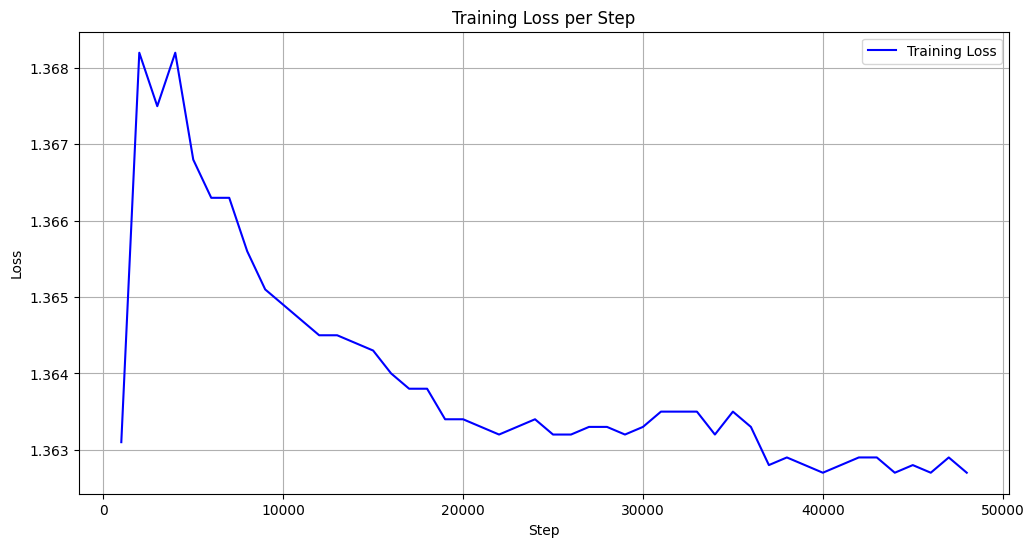

In [32]:
import json
import matplotlib.pyplot as plt

# Load the data from the JSON file
with open('./checkpoint-48000/trainer_state.json', 'r') as f:
    data = json.load(f)


# Extract training loss values and steps
training_loss = [log['loss'] for log in data['log_history'] if 'loss' in log]
steps = [log['step'] for log in data['log_history'] if 'loss' in log]


# Plotting the training loss
plt.figure(figsize=(12, 6))

# Training loss
plt.plot(steps, training_loss, label='Training Loss', color='blue')

# Add title and labels
plt.title('Training Loss per Step')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

# Show plot
plt.grid(True)
plt.show()



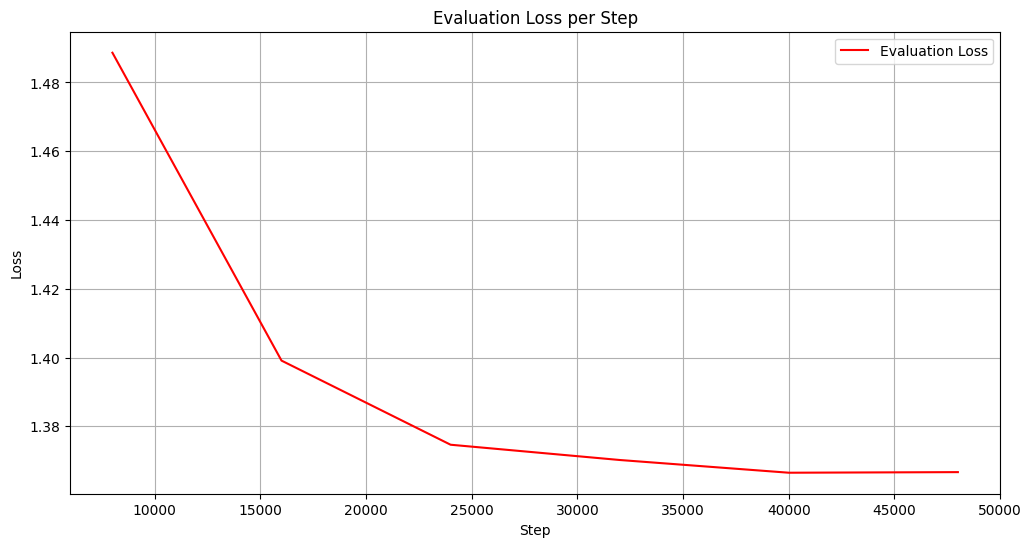

In [33]:
import json
import matplotlib.pyplot as plt

# Load the data from the JSON file
with open('./checkpoint-48000/trainer_state.json', 'r') as f:
    data = json.load(f)

# Extract evaluation loss values and steps
eval_loss = [log['eval_loss'] for log in data['log_history'] if 'eval_loss' in log]
eval_steps = [log['step'] for log in data['log_history'] if 'eval_loss' in log]

# Plotting the evaluation loss
plt.figure(figsize=(12, 6))

# Evaluation loss
plt.plot(eval_steps, eval_loss, label='Evaluation Loss', color='red')

# Add title and labels
plt.title('Evaluation Loss per Step')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

# Show plot
plt.grid(True)
plt.show()


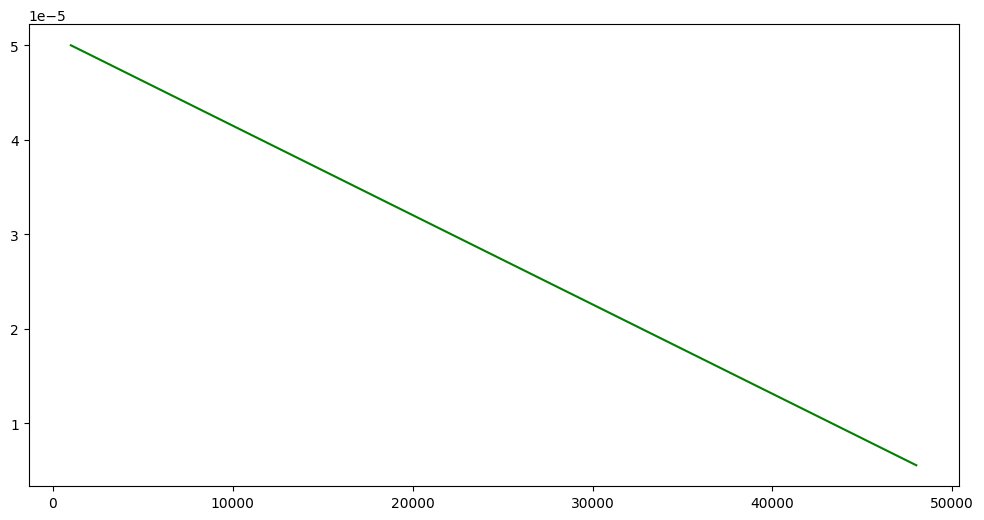

In [34]:
#plot learning_rate

# Load the data from the JSON file
with open('./checkpoint-48000/trainer_state.json', 'r') as f:
    data = json.load(f)

# Extract learning rate values and steps
learning_rate = [log['learning_rate'] for log in data['log_history'] if 'learning_rate' in log]
steps = [log['step'] for log in data['log_history'] if 'learning_rate' in log]

# Plotting the learning rate
plt.figure(figsize=(12, 6))

# Learning rate
plt.plot(steps, learning_rate, label='Learning Rate', color='green')

In [38]:
# load from pretrained checkpoint 53835
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("./checkpoint-53835/")

In [40]:
import datasets
from transformers import BertTokenizer, EncoderDecoderModel
rouge = datasets.load_metric("rouge")

model.to("cuda")

test_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="test")

batch_size = 64 # change to 64 for full evaluation

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    # cut off at BERT max length 512
    inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["article"])

pred_str = results["pred"]
label_str = results["highlights"]

rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

print(rouge_output)

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

Score(precision=0.1613017406440283, recall=0.17057274191408112, fmeasure=0.16098247318003284)


In [41]:
#represent fmeasure as a percentage
print(f"ROUGE-2: {rouge_output.fmeasure * 100:.2f}")

ROUGE-2: 16.10
